In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("meteo_data.csv")
df

,SOLAR_RADIATION,PRECIPITATION,WIND_SPEED,LEAF_WETNESS,HC_AIR_TEMPERATURE,HC_RELATIVE_HUMIDITY,DEW_POINT,Date
0,0.0,0.0,0.1,0.0,15.81,100.00,15.7,2022-09-21 20:00:00
1,0.0,0.0,0.0,0.0,15.81,100.00,15.7,2022-09-21 21:00:00
2,0.0,0.0,0.2,0.0,15.83,88.69,0.0,2022-09-21 22:00:00
3,0.0,0.0,0.3,0.0,15.97,73.08,11.0,2022-09-21 23:00:00
4,0.0,0.0,1.1,0.0,15.55,61.41,8.0,2022-09-22 00:00:00
...,...,...,...,...,...,...,...,...
13709,539.0,0.0,5.5,0.0,19.05,91.66,0.0,2024-04-15 15:00:00
13710,428.0,0.0,5.7,0.0,19.23,0.00,0.0,2024-04-15 16:00:00
13711,277.0,0.0,5.0,0.0,18.33,0.00,0.0,2024-04-15 17:00:00
13712,135.0,0.0,4.9,0.0,17.47,25.00,0.0,2024-04-15 18:00:00


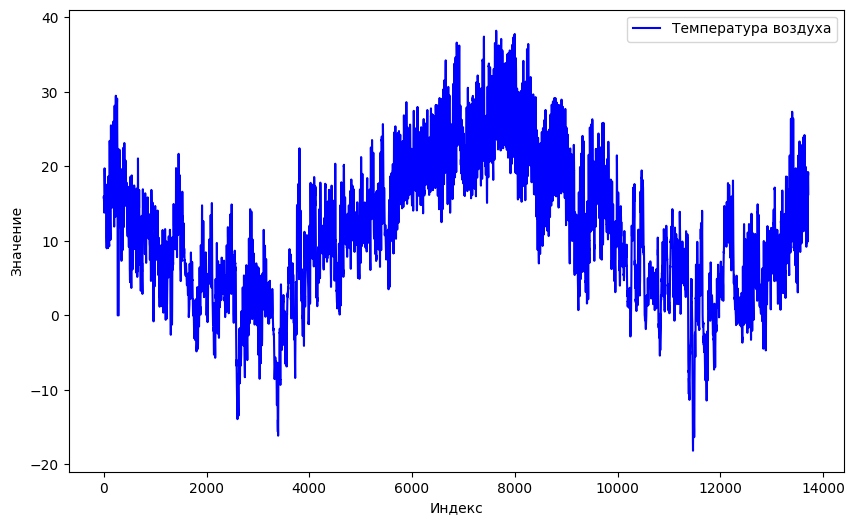

In [3]:
temp = df['HC_AIR_TEMPERATURE']

# Создание массива индексов для оси X
indices = np.arange(len(temp))

plt.figure(figsize=(10, 6))
plt.plot(indices, temp, label='Температура воздуха', color='blue')

# Настройка графика
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [4]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [5]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((13709, 5, 1), (13709,))

In [6]:
X_train1, y_train1 = X1[:10500], y1[:10500]
X_val1, y_val1 = X1[10500:12000], y1[10500:12000]
X_test1, y_test1 = X1[12000:], y1[12000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((10500, 5, 1), (10500,), (1500, 5, 1), (1500,), (1709, 5, 1), (1709,))

In [7]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
cp2 = ModelCheckpoint('model2/model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [9]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp2])

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 150.7545 - root_mean_squared_error: 12.2489 - val_loss: 8.4521 - val_root_mean_squared_error: 2.9093
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.6597 - root_mean_squared_error: 5.3882 - val_loss: 3.0519 - val_root_mean_squared_error: 1.7484
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8703 - root_mean_squared_error: 2.6184 - val_loss: 2.0912 - val_root_mean_squared_error: 1.4472
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1746 - root_mean_squared_error: 2.0405 - val_loss: 1.6666 - val_root_mean_squared_error: 1.2918
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8939 - root_mean_squared_error: 1.7008 - val_loss: 1.4453 - val_root_mean_squared_error: 1.2030
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7441 - root_mean_squared_error: 1.6538 - val_loss: 1.2238 - val_root_mean_squared_error: 1.1069
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


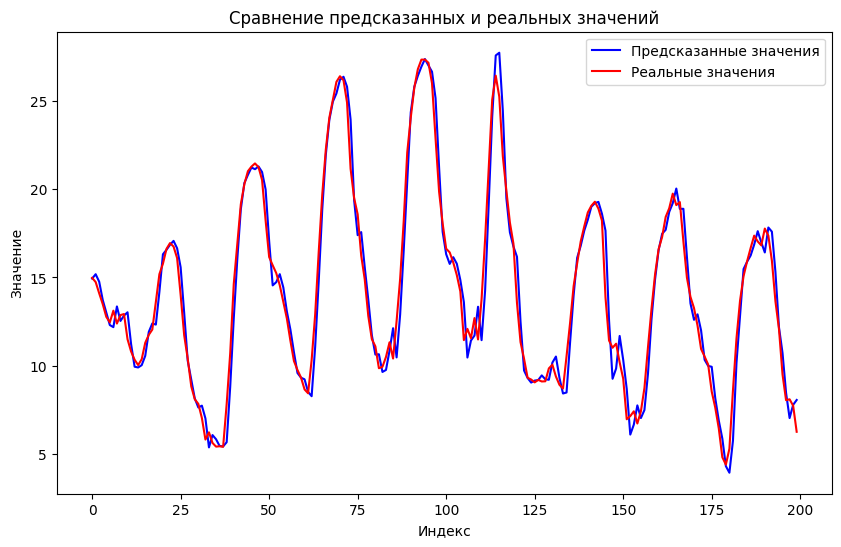

In [10]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[1300:1500], label='Предсказанные значения', color='blue')
plt.plot(y_test1[1300:1500], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [11]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 0.6251365968431556
Средняя квадратичная ошибка (MSE): 0.7835837932183859
Корень из среднеквадратичной ошибки (RMSE): 0.8852026848233041
Коэффициент детерминации (R^2): 0.9796842689521083
